# Housing economy, home prices and affordibility

Alan Greenspan in 2014 pointed out that there was never a recovery from recession 
without improvements in housing construction. Here we examine some relevant data, 
including the Case-Shiller series, and derive an insightful 
measure of the housing economy, **hscore**, which takes affordibility into account.

Contents:

- Housing Starts
- Constructing a Home Price Index
- Real home prices
- Indebtedness for typical home buyer
- hscore: Housing starts scored by affordability
- Concluding remarks

*Dependencies:*

- Repository: https://github.com/rsvp/fecon235
- Python: matplotlib, pandas

*CHANGE LOG*

    2016-02-08  Fix issue #2 by v4 and p6 updates.
                   Our hscore index has been completely revised.
                   Another 12 months of additional data.
    2015-02-10  Code review and revision.
    2014-09-11  First version.

In [1]:
from fecon235.fecon235 import *

In [2]:
#  PREAMBLE-p6.15.1223 :: Settings and system details
from __future__ import absolute_import, print_function
system.specs()
pwd = system.getpwd()   # present working directory as variable.
print(" ::  $pwd:", pwd)
#  If a module is modified, automatically reload it:
%load_ext autoreload
%autoreload 2
#       Use 0 to disable this feature.

#  Notebook DISPLAY options:
#      Represent pandas DataFrames as text; not HTML representation:
import pandas as pd
pd.set_option( 'display.notebook_repr_html', False )
#  Beware, for MATH display, use %%latex, NOT the following:
#                   from IPython.display import Math
#                   from IPython.display import Latex
from IPython.display import HTML # useful for snippets
#  e.g. HTML('<iframe src=http://en.mobile.wikipedia.org/?useformat=mobile width=700 height=350></iframe>')
from IPython.display import Image 
#  e.g. Image(filename='holt-winters-equations.png', embed=True) # url= also works
from IPython.display import YouTubeVideo
#  e.g. YouTubeVideo('1j_HxD4iLn8', start='43', width=600, height=400)
from IPython.core import page
get_ipython().set_hook('show_in_pager', page.as_hook(page.display_page), 0)
#  Or equivalently in config file: "InteractiveShell.display_page = True", 
#  which will display results in secondary notebook pager frame in a cell.

#  Generate PLOTS inside notebook, "inline" generates static png:
%matplotlib inline   
#          "notebook" argument allows interactive zoom and resize.

 ::  Python 2.7.11
 ::  IPython 4.0.0
 ::  jupyter 1.0.0
 ::  notebook 4.0.6
 ::  matplotlib 1.4.3
 ::  numpy 1.10.1
 ::  pandas 0.17.1
 ::  pandas_datareader 0.2.0
 ::  Repository: fecon235 v4.16.0123 develop
 ::  Timestamp: 2016-02-10, 20:12:07 UTC
 ::  $pwd: /media/yaya/virt15h/virt/dbx/Dropbox/ipy/fecon235/nb


## Housing Starts

*Housing starts* is an economic indicator that reflects the number of 
privately owned new houses (technically housing units) on which 
construction has been started in a given period. 
We retrieve monthly data released by the U.S. Bureau of the Census. 

In [3]:
#  In thousands of units:
hs = get( m4housing )
#         m4 indicates monthly frequency.

In [4]:
#  plot( hs )

Since housing is what houses people, over the long-term 
it is reasonable to examine **housing starts per capita**.

In [5]:
#  US population in thousands:
pop = get( m4pop )

In [6]:
#  Factor 100.00 converts operation to float and percentage terms:
hspop = todf((hs * 100.00) / pop)

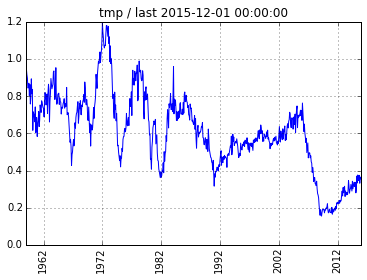

In [7]:
plot( hspop )

**At the peaks, about 1% of the *US population got allocated new housing monthly*.
The lowest point shown is after the Great Recession at 0.2%.**

Clearly there's a downward historical trend, so to discern **short-term housing cycles**,
we detrend and normalize hspop.

 ::  regresstime slope = -0.000742599274435


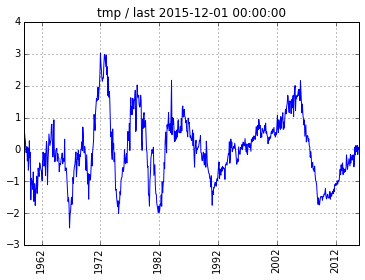

In [8]:
plot(detrendnorm( hspop ))

Surprisingly, housing starts per capita during the Great Recession did not
exceed two standard deviations on the downside. 

2015-02-10 and 2016-02-08:  It appears that housing starts has recovered relatively
and is back to mean trend levels.

In the concluding section, we shall derive another measure of housing activity
which takes affordibility into account.

## Constructing a Home Price Index

The correlation between Case-Shiller indexes, 20-city vs 10-city, is practically 1.
Thus a mash-up is warranted to get data extended back to 1987.
Case-Shiller is not dollar denominated (but rather a chain of changes)
so we use the median sales prices from 2000 to mid-2014 released by the
National Association of Realtors to estimate home price,
see function **gethomepx** for explicit details.

In [9]:
#  We can use ? or ?? to extract code info:
gethomepx??

Signature: gethomepx(fredcode='m4homepx')
Source:
def gethomepx( fredcode=m4homepx ):
     '''Make Case-Shiller 20-city, and try to prepend 1987-2000 10-city.'''
     #  Fred's licensing may change since source is S&P, 
     #  however, we have a local copy of 1987-2013 monthly SA data.
     hpnow = getdata_fred( 'SPCS20RSA' )
     #                          20-city home price index back to 2000-01-01.
     try:
          hpold = readfile( 'FRED-home-Case-Shiller_1987-2013.csv.gz', compress='gzip' )
          #                 ^includes 10-city index from 1987-2000.
          #                  Current correlation with 20-city: 0.998
          #                  Thus the mashup is justified.
          hpall = hpold.combine_first( hpnow )
          #             ^appends dataframe
          print(' ::  Case-Shiller prepend successfully goes back to 1987.')
     except:
          hpall = hpnow
          print(' ::  Case-Shiller since 2000 (1987-archive not found).')
     #  Case-Shiller 

In [10]:
#  Our interface will not ask the user to enter such messy details...
homepx = get( m4homepx )
#             m4 indicates monthly home prices.

 ::  Case-Shiller prepend successfully goes back to 1987.


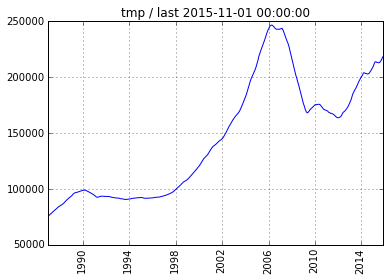

In [11]:
#  Case-Shiller is seasonally adjusted:
plot( homepx )
#  so the plot appears relatively smooth. 

In [12]:
#  Geometric rate of return since 1987:
georet( homepx, 12 )

[3.7, 3.73, 2.52, 12, 347, '1987-01-01', '2015-11-01']

The first element tells us home prices have increased
approximately 3.7% per annum.
The third element shows price volatility of 2.5%
which is very low compared to other asset classes.

But this does not take into account inflation.
In any case, recent home prices are still below
the levels just before the Great Recession.

## Real home prices

In [13]:
#  This is an synthetic deflator created from four sources:
#  CPI and PCE, both headline and core:
defl = get( m4defl )

In [14]:
#  "Real" will mean in terms of current dollars:
homepxr = todf( homepx * defl )
#     r for real 

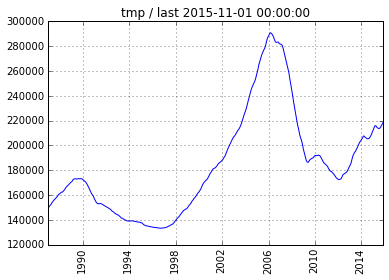

In [15]:
plot( homepxr )

In [16]:
#  Real geometric return of home prices:
georet( homepxr, 12 )

[1.32, 1.35, 2.54, 12, 347, '1987-01-01', '2015-11-01']

*Real* home prices since 1987 have increased at the approximate
rate of +1.3% per annum.

Note that the above does not account for annual property taxes
which could diminish of real price appreciation.

Perhaps home prices are only increasing because new stock of housing
has been declining over the long-term (as shown previously).

The years 1997-2006 is considered a **housing bubble**
due to the widespread availability of *subprime mortgages*
(cf. NINJA, No Income No Job Applicant, was often not rejected.)
**Median home prices *doubled* in real terms**: from \$140,000 to \$280,000.

**Great Recession took down home prices** (180-280)/280 = **-36% in real terms.**

2015-02-10: we are roughly at 200/280 = 71% of peak home price in real terms.

2016-02-08: we are roughly at 220/280 = 79% of peak home price in real terms.

## Indebtedness for typical home buyer

For a sketch, we assume a fixed premium for some long-term mortgages over 10-y Treasuries,
and then compute the number of hours needed to 
pay *only the interest on the full home price* (i.e. no down payment assumed).

This sketch does not strive for strict veracity, but simply serves as an
indicator to model the housing economy.

In [17]:
mortpremium = 1.50

In [18]:
mortgage = todf( get(m4bond10) + mortpremium )

In [19]:
#  Yearly interest to be paid off:
interest = todf( homepx * (mortgage / 100.00) )

In [20]:
#  Wage is in dollars per hour:
wage = get( m4wage )

In [21]:
#  Working hours to pay off just the interest:
interesthours = todf( interest / wage )

In [22]:
#  Mortgage interest to be paid as portion of ANNUAL income,
#  assuming 2000 working hours per year:
payhome = todf( interesthours / 2000.00 )

#  We ignore tiny portion of mortgage payment made towards reducing principal.
#  And of course, the huge disparity in earned income among the population.

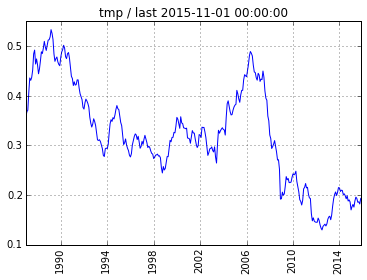

In [23]:
plot( payhome )

If we assume 2000 hours worked per year (40 hours for 50 weeks), we can see that
interest payment can potentially take up to 50% of total annual pre-tax income. 

2015-02-10: Currently that figure is about 20% so housing should be affordable,
but the population is uncertain about the risk on taking on debt.
(What if unemployment looms in the future?) 

Prospects of deflation adds to the fear of such risk.
Debt is best taken on in inflationary environments.

The housing bubble clearly illustrated that
huge *price risk* of the underlying asset could be an important consideration.

Thus the renting a home (without any equity stake) may appear preferable over buying a home.

In [24]:
#  #  Forecast payhome for the next 12 months:
#  forecast( payhome, 12 )

2016-02-09: Homes should be slightly more affordable: 19% of annual income -- perhaps
due to further declining interest rates, or even some
increase in wages for the typical American worker.

Caution: although the numbers may indicate increased affordability,
it has become *far more difficult to obtain mortgage financing due to
strict credit requirements*. The pendulum of scrutiny from the NINJA days of the
subprime era has swung to the opposite extreme.
Subprime mortgages were the root cause of the Great Recession.
This would require another notebook which studies credit flows
from financial institutions to home buyers.

Great Recession: There is evidence recently that families shifted to home rentals,
avoiding home ownership which would entail taking on mortgage debt.
Some home owners experienced negative equity.
And when the debt could not be paid due to wage loss, it seemed reasonable to
walk away from their homes, even if that meant damage to their credit worthiness.
*Housing construction had to compete with a large supply of foreclosed homes on the market.*

## hscore: Housing starts scored by affordability

The basic idea here is that housing starts can be weighted by some
proxy of "affordability."
An unsold housing unit cannot be good for a healthy economy.

Recall that our variable *payhome* was constructed as a function of
home price, interest rate, and wage income -- to solve for the portion
of annual income needed to pay off a home purchase -- i.e. indebtedness.

**Home affordability** can thus be *abstractly* represented as 0 < (1-payhome) < 1,
by ignoring living expenses of the home buyer.

In [25]:
afford = todf( 1 - payhome )

In [26]:
#  hspop can be interpreted as the percentage of the population allocated new housing.

#  Let's weight hspop by afford to score housing starts...
hscore = todf( hspop * afford )

#  ... loosely interpretated as new "affordable" housing relative to population.

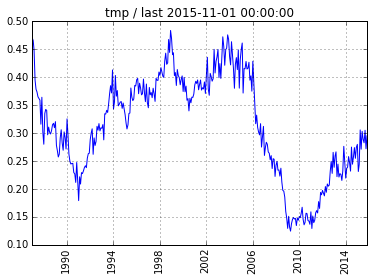

In [27]:
plot( hscore )

In [28]:
stat( hscore )

                Y
count  347.000000
mean     0.313257
std      0.091287
min      0.124288
25%      0.244456
50%      0.316766
75%      0.387574
max      0.483924


**hscore** can be roughly interpreted as "affordable" housing starts
expressed as percentage of the total U.S. population.

The overall mean of *hscore* is approximately 0.31, and we observe a band between
0.31 and 0.47 from 1993 to 2004.
That band could  be interpreted as an equilibrium region for the housing economy
(before the Housing Bubble and Great Recession).
It's also worth noting that long-term interest rates during that epoch was
determined by the market -- yet untouched by the massive *quantitative easing*
programs initiated by the Federal Reserve.

In [29]:
#  Forecast for hscore, 12-months ahead:
forecast( hscore, 12 )

    Forecast
0   0.295048
1   0.297774
2   0.300460
3   0.303146
4   0.305832
5   0.308518
6   0.311204
7   0.313890
8   0.316576
9   0.319262
10  0.321948
11  0.324634
12  0.327320

## Concluding remarks

We created an index **hscore** which expresses new "affordable" housing units
as percentage of total population. Affordability was crudely modeled by a few
well-known economic variables, plus our extended Case-Schiller index
of median home prices.

- 2016-02-09  Following the Great-Recession lows around 0.13, *hscore* has now reverted to its long-term mean of 0.31, *confirming the recovery*, and is forecasted to slightly increase to 0.33.


- The Fed terminated its QE program but has not sold off any of its mortgage securities. That reduces upward pressure on mortgage rates. However, our *hscore* supports the Fed's rate hike decision on 2015-12-16 since it gives evidence that the housing market has recovered midway between the housing bubble and the subprime mortgage crisis.